# Deep Neural Networks (PyTorch)

The following notebook is dedicated to supervised machine learning for the <b> SUSY tau+X </b> search analysis. The continuation of the [paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.99.012009) involves implementation of machine learning techniques, with a focus on the Deep Neural Networks.

<b> Deep Neural Networks </b> (DNNs) is a highly popular, powerful and widely recognized machine learning algorithm in High-Energy Physics community.  An optimized neural network library called <b> PyTorch </b> has been implemented. PyTorch is an open-source library providing a dedicated neural network framework.

Learning objectives:
* Regression
* Binary-classification
* Multiclass-classification

Functionalities:
* Rectangularization & Padding
* Stopping function preventing overfitting
* Training with or without weights
* Cross-validation
    * k-fold cross-validation
* Hyperparameters tuning:
    * randomized grid-search
    * exhaustive grid-search
* GPU computing

## Initialization

### Libraries

Required python packages:

ROOT I/O:

* [UpROOT](https://uproot.readthedocs.io/en/latest/)

Data Processing:

* [Awkward Array](https://awkward-array.readthedocs.io/en/latest/)
* [NumPy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)

Data Visualization:

* [Atlas MPL Style](https://atlas-mpl.readthedocs.io/en/latest/styles.html)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)

Machine Learning:

* [SciPy](https://scipy.org/)
* [SkLearn](https://scikit-learn.org/stable/)
* [PyTorch](https://pytorch.org/)
* [SHAP](https://shap.readthedocs.io/en/latest/)

Other:

* [tqdm](https://tqdm.github.io/)
* [pickle](https://docs.python.org/3/library/pickle.html)

In [1]:
import uproot as ur

import awkward as ak
import numpy as np
import pandas as pd

import atlas_mpl_style as ampl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import shap

from tqdm import tqdm
import pickle

import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import warnings
import os, sys
from pathlib import Path

### Tweaks

Supressing warnings.

In [2]:
warnings.filterwarnings('ignore')

Activating auto reload of imported modules.

In [3]:
%load_ext autoreload
%autoreload 2

Applying ATLAS style and LaTeX compatibility.

In [4]:
os.environ['PATH'] += '/cvmfs/sft.cern.ch/lcg/external/texlive/2020/bin/x86_64-linux'
plt.rc('text', usetex=True)             # Matplotlib LaTeX Compatibility
ampl.use_atlas_style(usetex=True)       # ATLAS Style

### Paths

Defining working paths.

In [5]:
sys.path.append(str(Path(os.getcwd()).parent) + '/Scripts/Definers/')
from PathsDefiner import paths_definer
path_pickles = paths_definer()

## Definition

Selecting the analysis of interest.

In [6]:
run = 'Run2'
analysis_base = '24.2.28'
region = 'Preselection'
channel = '2'

## Deserialization

Deserializing the dataframe.

In [7]:
with open(f"{path_pickles}/ML/{analysis_base}/{run}/{region}/{channel}_tau/dataframe.pkl", "rb") as file:
    dataframe = pickle.load(file)

## Deep Neural Networks

Defining a type of a framework.

In [8]:
framework_type = 'PyTorch'

### Task

Determining the learning objective:
* Regression
* Binary-classification
* Multiclass-classification

In [9]:
# algorithm_type = 'regression'
# algorithm_type = 'binary-classification'
algorithm_type = 'multiclass-classification'

### Signal Class

For the multiclass-classification, signal can be considered as:
* 1 signal class (signal_as_one),
* 2 signal classes (signal_type),
* 6 signal classes (signal_mass) - default.


In [10]:
signal_format = 'signal_as_one'
# signal_format = 'signal_type'
# signal_format = 'signal_mass'

In [11]:
# if signal_format == 'signal_as_one':
#     dataframe['df']['class'].replace([6, 7, 8, 9, 10, 11], 6, inplace = True)
#     dataframe['labels'] = dataframe['labels'][:-6] + ['signal']
# elif signal_format == 'signal_type':
#     dataframe['df']['class'].replace([6, 7, 8], 6, inplace=True)
#     dataframe['df']['class'].replace([9, 10, 11], 7, inplace=True)
#     dataframe['labels'] = dataframe['labels'][:-6] + ['$\\breve g \\breve g$', '$\\breve s \\breve s$']
# elif signal_format == 'signal_mass':
#     pass

### Preview

Previewing the processed rectangular data as a dataframe.

In [12]:
dataframe['df']

nVtx  LeptonVeto  tau_n  jet_n  jet_n_btag  ele_n  mu_n  \
entry                                                              
0          22        True      2      6           0      0     0   
1          11       False      2      3           0      0     0   
2          11        True      2      3           1      0     0   
3           8        True      2      4           2      0     0   
4          13        True      2      3           2      0     0   
...       ...         ...    ...    ...         ...    ...   ...   
1388740    30        True      2      3           0      0     0   
1388741    25        True      2      3           0      0     0   
1388742    23        True      2      3           1      0     0   
1388743    10        True      2      6           0      0     0   
1388744    23        True      2      6           0      0     0   

                 sumMT      sumMTJet   sumMTTauJet  ...  jet_eleMatch_0  \
entry                                               ...                   
0        122664.187500  1.200299e+06  1.322963e+06  ...               0   
1        153499.390625  7.500236e+05  9.035229e+05  ...               0   
2        100656.859375  8.841444e+05  9.848012e+05  ...               0   
3        210207.203125  8.842624e+05  1.094470e+06  ...               0   
4        181634.984375  8.726021e+05  1.054237e+06  ...               0   
...                ...           ...           ...  ...             ...   
1388740  331089.750000  3.314850e+06  3.645940e+06  ...               0   
1388741  167696.937500  1.465636e+06  1.633333e+06  ...               0   
1388742   31196.849609  1.329502e+06  1.360699e+06  ...               0   
1388743  289854.406250  1.523172e+06  1.813026e+06  ...               0   
1388744  232104.375000  1.579506e+06  1.811610e+06  ...               0   

         jet_eleMatch_1  jet_eleMatch_2  jet_muMatch_0  jet_muMatch_1  \
entry                                                                   
0                     0             0.0              0              0   
1                     0             0.0              0              0   
2                     0             0.0              0              0   
3                     0             0.0              0              0   
4                     0             0.0              0              1   
...                 ...             ...            ...            ...   
1388740               0             0.0              0              0   
1388741               0             0.0              0              0   
1388742               0             0.0              0              0   
1388743               0             0.0              0              0   
1388744               0             0.0              0              0   

         jet_muMatch_2  jet_timing_0  jet_timing_1  jet_timing_2  \
entry                                                              
0                  0.0      0.197181     -0.083975      0.038682   
1                  0.0      0.058463      0.964934     -1.163602   
2                  0.0      0.192587     -0.235954      0.362056   
3                  0.0     -0.151218      0.481597     -0.023252   
4                  0.0      0.102353      0.290844     -0.259995   
...                ...           ...           ...           ...   
1388740            0.0      0.059946      0.045914     -0.190761   
1388741            0.0      0.024125     -1.116385     -5.647985   
1388742            0.0      0.080618     -0.158392     -2.319552   
1388743            0.0      0.212576      0.655231     -0.116148   
1388744            0.0      0.023419      0.239091     -0.685700   

              selection_name  
entry                         
0                  topquarks  
1                  topquarks  
2                  topquarks  
3                  topquarks  
4                  topquarks  
...                      ...  
1388740  GG_900_870_J85_1tau  
1388741  GG_900_870_J85_1tau  
138

Saving the dataframe.

#### Min & Max Value

Checking min and max values of a given feature with respect to its class.

In [13]:
from MinMaxChecker import min_max_checker

Min and max value of the <b> "weight" </b> feature:

In [14]:
min_max_checker(
    df = dataframe['df'], 
    feature_name = 'weight'
)

class       min      max
0     1  -2.2e-01  3.8e-01
1     2  -1.1e+01  4.8e+00
2     3  -5.3e-01  5.8e-01
3     4  -3.2e-01   3.e-01
4     5  -1.0e+00  1.7e+00
5     6  -1.8e+02  3.3e+02

#### Missing Values

Checking missing values.

In [15]:
dataframe['df'].isnull().sum()

nVtx              0
LeptonVeto        0
tau_n             0
jet_n             0
jet_n_btag        0
                 ..
jet_muMatch_2     0
jet_timing_0      0
jet_timing_1      0
jet_timing_2      0
selection_name    0
Length: 97, dtype: int64

In [16]:
for key,value in dataframe['df'].isnull().sum().iteritems():
    if value!=0:
        print(key,",",value)

#### Class Weight

In [17]:
max_count = dataframe['df']['class'].value_counts().min()
class_weights = max_count / dataframe['df']['class'].value_counts()
dataframe['df']['class_weight'] = dataframe['df']['class'].map(class_weights)

In [18]:
class_weights = class_weights.sort_index()
class_weights

0    0.736891
1    1.000000
2    0.038587
3    0.188332
4    0.068159
5    0.031230
Name: class, dtype: float64

### Balance

Checking the balance of the data with and without taking into account the "weight" feature.

In [19]:
from BalancePlotter import balance_plotter

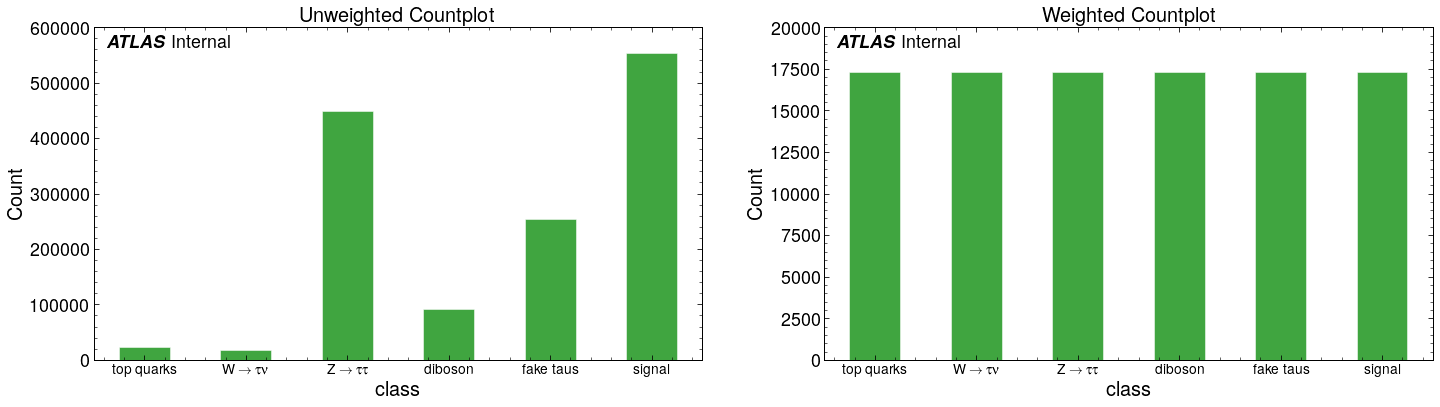

In [20]:
balance_plotter(
    algorithm_type = algorithm_type, 
    df = dataframe['df'], 
    labels = dataframe['labels']
)

In [21]:
dataframe['df']

nVtx  LeptonVeto  tau_n  jet_n  jet_n_btag  ele_n  mu_n  \
entry                                                              
0          22        True      2      6           0      0     0   
1          11       False      2      3           0      0     0   
2          11        True      2      3           1      0     0   
3           8        True      2      4           2      0     0   
4          13        True      2      3           2      0     0   
...       ...         ...    ...    ...         ...    ...   ...   
1388740    30        True      2      3           0      0     0   
1388741    25        True      2      3           0      0     0   
1388742    23        True      2      3           1      0     0   
1388743    10        True      2      6           0      0     0   
1388744    23        True      2      6           0      0     0   

                 sumMT      sumMTJet   sumMTTauJet  ...  jet_eleMatch_1  \
entry                                               ...                   
0        122664.187500  1.200299e+06  1.322963e+06  ...               0   
1        153499.390625  7.500236e+05  9.035229e+05  ...               0   
2        100656.859375  8.841444e+05  9.848012e+05  ...               0   
3        210207.203125  8.842624e+05  1.094470e+06  ...               0   
4        181634.984375  8.726021e+05  1.054237e+06  ...               0   
...                ...           ...           ...  ...             ...   
1388740  331089.750000  3.314850e+06  3.645940e+06  ...               0   
1388741  167696.937500  1.465636e+06  1.633333e+06  ...               0   
1388742   31196.849609  1.329502e+06  1.360699e+06  ...               0   
1388743  289854.406250  1.523172e+06  1.813026e+06  ...               0   
1388744  232104.375000  1.579506e+06  1.811610e+06  ...               0   

         jet_eleMatch_2  jet_muMatch_0  jet_muMatch_1  jet_muMatch_2  \
entry                                                                  
0                   0.0              0              0            0.0   
1                   0.0              0              0            0.0   
2                   0.0              0              0            0.0   
3                   0.0              0              0            0.0   
4                   0.0              0              1            0.0   
...                 ...            ...            ...            ...   
1388740             0.0              0              0            0.0   
1388741             0.0              0              0            0.0   
1388742             0.0              0              0            0.0   
1388743             0.0              0              0            0.0   
1388744             0.0              0              0            0.0   

         jet_timing_0  jet_timing_1  jet_timing_2       selection_name  \
entry                                                                    
0            0.197181     -0.083975      0.038682            topquarks   
1            0.058463      0.964934     -1.163602            topquarks   
2            0.192587     -0.235954      0.362056            topquarks   
3           -0.151218      0.481597     -0.023252            topquarks   
4            0.102353      0.290844     -0.259995            topquarks   
...               ...           ...           ...                  ...   
1388740      0.059946      0.045914     -0.190761  GG_900_870_J85_1tau   
1388741      0.024125     -1.116385     -5.647985  GG_900_870_J85_1tau   
1388742      0.080618     -0.158392     -2.319552  GG_900_870_J85_1tau   
1388743      0.212576      0.655231     -0.116148  GG_900_870_J85_1tau   
1388744      0.023419      0.239091     -0.685700  GG_900_870_J85_1tau   

         class_weight  
entry                  
0            0.736891  
1            0.736891  
2            0.736891  
3            0.736891  
4            0.736891  
...               ...  
1388740      0.031230  
1388741      0.031230  
1388742 

### Shuffle

Shuffling the data to prevent any correlations.

In [22]:
# df = df.sample(frac=1)
# df

### Feature(s) Dropping

Dropping particular features of interest to see how much the correlation and feature importance plots change.

In [23]:
from FeatureDropper import feature_dropper

(1) Dropping the desired feature.

In [24]:
feature_dropper(False)

# feature_drop(True, 'single', 'jet_isBjet_0')
# feature_drop(True, 'single', 'jet_isBjet_1')
# feature_drop(True, 'single', 'jet_isBjet_2')

No dropping performed.


(2) Dropping all features except the desired feature.

In [25]:
feature_dropper(False)

# feature_drop(True, 'all', 'jet_isBjet_0')

No dropping performed.


### Objective & Metric

Defining an objective and a metric.

In [26]:
from ObjectiveDefiner import objective_definer

In [27]:
criterion = objective_definer(
    algorithm_type = algorithm_type,
    framework_type = framework_type
)

### Train-Test Split

Splitting the data into train and test subsets. Depending on the type of the algorithm, a label is determined as follows:
* for regression, the $y$-label is set according to the Feature_Regression.py,
* for binary- and multiclass-classification, the $y$-label is set as the "class" feature.

In [28]:
from TrainTestSplitter import train_test_splitter

In [29]:
X, y, X_train, X_test, y_train, y_test = train_test_splitter(
    algorithm_type = algorithm_type, 
    df = dataframe['df'], 
    test_size = 0.3
)

### Selection

In [30]:
X_train_selection_name = X_train['selection_name']
X_test_selection_name = X_test['selection_name']

In [31]:
X.drop(
    'selection_name',
    axis=1, 
    inplace=True
)
X_train.drop(
    'selection_name', 
    axis=1, 
    inplace=True
)
X_test.drop(
    'selection_name',
    axis=1, 
    inplace=True
)

### Weights

There are some difficulties applying negative weights during the training process of a model. Currently, there are 2 known ways to handle this:
* not applying weights at all during the training process,
* applying weights with events that have positive weights only during the training process and evaluating with all weights (events with both positive and negative weights):
    * without normalization,
    * with normalization.

#### Histogram Weights

Extracing weights for histograms.

In [32]:
df_weights = dataframe['df']['weight']
X_train_weights = X_train['weight']
X_test_weights = X_test['weight']

#### Training Weights

Extracing class weights for the training process.

In [33]:
df_class_weights = dataframe['df']['class_weight']
X_class_test_weights = X_test['class_weight']
X_class_train_weights = X_train['class_weight']

#### Negative Weights

Transfering events with negative weights from the train to the test sample.

Defining weights for the training process.

In [34]:
from NegativeWeightApplier import negative_weight_applier

Creating a weight array to be applied during the training process.

In [35]:
apply_negative_weight = False           # True | False
normalize = False                       # True | False

In [36]:
if apply_negative_weight:
    X_train, X_test, y_train, y_test, X_train_weights, X_test_weights = negative_weight_applier(
        apply_negative_weight = apply_negative_weight, 
        normalize = normalize, 
        X_train = X_train, 
        y_train = y_train, 
        X_test = X_test, 
        y_test = y_test
    )
else:
    negative_weight_applier(
        apply_negative_weight = apply_negative_weight
    )

No weight applied.


Dropping the weight feature

In [37]:
X.drop(
    [
        'weight',
        'class_weight'
    ],
    axis=1, 
    inplace=True
)
X_train.drop(
    [
        'weight',
        'class_weight'
    ],
    axis=1, 
    inplace=True
)
X_test.drop(
    [
        'weight',
        'class_weight'
    ],
    axis=1, 
    inplace=True
)

### Normalization

Normalization is required in neural network algorithms. Normalization is based on X_train (0-1) and extended to X_test (0-1 are not preserved). In addition, data is transformed into pytorch tensors.
1. Extracting values from the dataframe.
2. Normalizing training and testing data.
3. Enabling GPU computing.
4. Converting data to pytorch tensor type. Passing to GPU pipeline.

In addition, it is possible to consider a given model using Automatic Mixed Precision (AMP) technique. AMP training combines both single-precision (float32) and half-precision (float16) floating-point data types to accelerate training while maintaining numerical stability.

In [38]:
AMP = True
# AMP = False

In [39]:
from NormalizationApplier import normalization_applier

In [40]:
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, device = normalization_applier(
    framework_type = framework_type,
    algorithm_type = algorithm_type,
    AMP = AMP,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test
)

GPU enabled.
Normalization performed.


In [41]:
if AMP:
    df_class_weights_tensor = torch.tensor(df_class_weights.values, dtype=torch.float16).to(device)
    X_class_test_weights_tensor = torch.tensor(X_class_test_weights.values, dtype=torch.float16).to(device)
    X_class_train_weights_tensor = torch.tensor(X_class_train_weights.values, dtype=torch.float16).to(device)
    class_weights = torch.tensor(class_weights.values, dtype=torch.float16).to(device)
else:
    df_class_weights_tensor = torch.tensor(df_class_weights.values, dtype=torch.float32).to(device)
    X_class_test_weights_tensor = torch.tensor(X_class_test_weights.values, dtype=torch.float32).to(device)
    X_class_train_weights_tensor = torch.tensor(X_class_train_weights.values, dtype=torch.float32).to(device)
    class_weights = torch.tensor(class_weights.values, dtype=torch.float16).to(device)

### Preview

Previewing the $ y $- and $ x $-subsets.

In [42]:
X.head()

nVtx  LeptonVeto  tau_n  jet_n  jet_n_btag  ele_n  mu_n          sumMT  \
entry                                                                           
0        22        True      2      6           0      0     0  122664.187500   
1        11       False      2      3           0      0     0  153499.390625   
2        11        True      2      3           1      0     0  100656.859375   
3         8        True      2      4           2      0     0  210207.203125   
4        13        True      2      3           2      0     0  181634.984375   

           sumMTJet   sumMTTauJet  ...  jet_width_2  jet_eleMatch_0  \
entry                              ...                                
0      1.200299e+06  1.322963e+06  ...     0.036778               0   
1      7.500236e+05  9.035229e+05  ...     0.211321               0   
2      8.841444e+05  9.848012e+05  ...     0.097620               0   
3      8.842624e+05  1.094470e+06  ...     0.178472               0   
4      8.726021e+05  1.054237e+06  ...     0.108371               0   

       jet_eleMatch_1  jet_eleMatch_2  jet_muMatch_0  jet_muMatch_1  \
entry                                                                 
0                   0             0.0              0              0   
1                   0             0.0              0              0   
2                   0             0.0              0              0   
3                   0             0.0              0              0   
4                   0             0.0              0              1   

       jet_muMatch_2  jet_timing_0  jet_timing_1  jet_timing_2  
entry                                                           
0                0.0      0.197181     -0.083975      0.038682  
1                0.0      0.058463      0.964934     -1.163602  
2                0.0      0.192587     -0.235954      0.362056  
3                0.0     -0.151218      0.481597     -0.023252  
4                0.0      0.102353      0.290844     -0.259995  

[5 rows x 94 columns]

In [43]:
y.head()

entry
0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

### Correlation

Checking the correlation of the label with the data.

In [44]:
from CorrelationPlotter import correlation_plotter

Plotting the feature correlation scores for the 20 most important features (vertically).

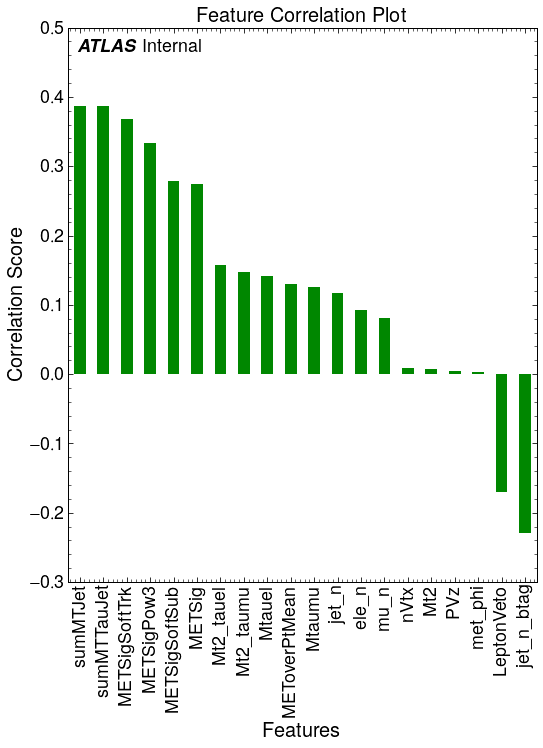

In [42]:
correlation_plotter(
    df = dataframe['df'], 
    y = y, 
    direction = "vertical", 
    n_features = 20
)

Plotting the feature correlation scores for the 20 most important features (horizontally).

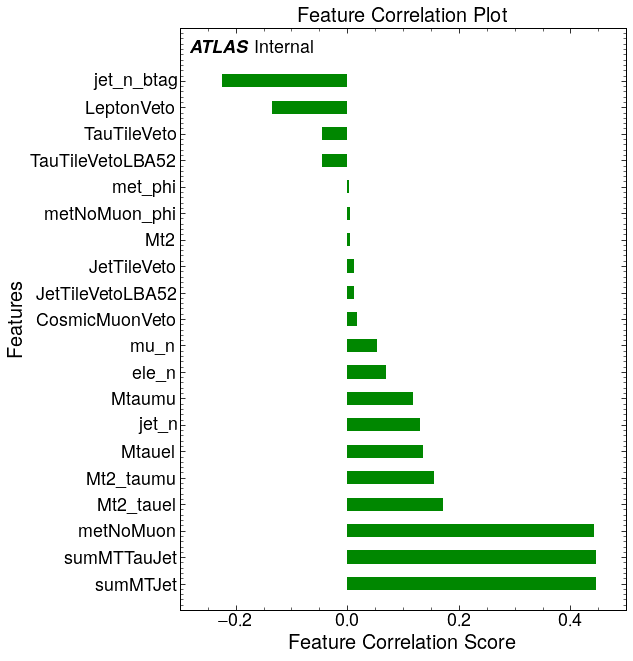

In [65]:
correlation_plotter(
    df = dataframe['df'], 
    y = y, 
    direction = "horizontal", 
    n_features = 20
)

### Parameters

Defining the initial hyperparameter values.

In [45]:
apply_weight = True

In [46]:
if apply_weight:
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    pass

In [47]:
# ---Network Size Parameters---
input_size = len(X_train.columns)                           # number of input features
hidden_size = [64, 64, 64]                                  # list of hidden layer sizes

if (algorithm_type == 'regression') or (algorithm_type == 'binary-classification'):
    output_size = 1                          # number of output classes
elif algorithm_type == 'multiclass-classification':
    output_size = len(np.unique(y))
else:
     raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")
# ---Network Size Parameters---

# ---Learning Task Parameters---
n_epochs = 10000                        # number of epochs
batch_size = None                       # the number of samples in a singla forward/backward pass
dropout = None                          # probability of randomly dropping out (setting to zero) neurons in the network during training
# ---Learning Task Parameters---

# ---Loss & Activation Functions---
criterion = criterion
activation = nn.ReLU()                  # nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softmax()
# ---Loss & Activation Functions---

# ---Optimizer Task Parameters---
learning_rate = 0.005                   # the step size at which the optimizer adjusts the model parameters during training
momentum = None                         # specifies the amount of momentum to apply to the weights of the network during training
weight_decay = None                     # specifies the amount of L2 regularization to apply to the weights of the network during training
# ---Optimizer Task Parameters---

Defining the fit parameter values.

In [48]:
apply_weight = True

In [49]:
early_stopping_rounds = 100

#### Neural Networks

In [50]:
from PyTorchNNCreator import PyTorchModel

In [51]:
pytorch_model = PyTorchModel(
    input_size = input_size, 
    hidden_size = hidden_size, 
    output_size = output_size,
    activation = activation,
    dropout = dropout
).to(device)

In [52]:
pytorch_model

PyTorchModel(
  (input_layer): Linear(in_features=94, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=6, bias=True)
)

Optimizer

In [53]:
optimizer = optim.Adam(                     # SGD, Adam
    pytorch_model.parameters(),
    lr = learning_rate
)

#### Fitting & Predicting

Fitting the model with hyper-and fit-parameters and making the predictions and estimating prediction probabilities (the latter only for binary- and multiclass-classification).

In [54]:
if AMP:
    from PyTorchFitterPredictorAMP import pytorch_fitter_predictor
else:
    from PyTorchFitterPredictor import pytorch_fitter_predictor

In [55]:
y_pred_val, training_loss_history, validation_loss_history, best_epoch = pytorch_fitter_predictor(
    algorithm_type = algorithm_type,
    pytorch_model = pytorch_model,
    n_epochs = n_epochs,
    optimizer = optimizer,
    criterion = criterion,
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_test_tensor = X_test_tensor,
    y_test_tensor = y_test_tensor,
    early_stopping_rounds = early_stopping_rounds
)

Epoch 1 -- Training Loss: 1.7972 -- Validation Loss: 1.7863
Epoch 11 -- Training Loss: 1.5160 -- Validation Loss: 1.4763
Epoch 21 -- Training Loss: 1.1921 -- Validation Loss: 1.1769
Epoch 31 -- Training Loss: 1.0778 -- Validation Loss: 1.0806
Epoch 41 -- Training Loss: 1.0278 -- Validation Loss: 1.0281
Epoch 51 -- Training Loss: 0.9924 -- Validation Loss: 0.9891
Epoch 61 -- Training Loss: 0.9640 -- Validation Loss: 0.9647
Epoch 71 -- Training Loss: 0.9410 -- Validation Loss: 0.9424
Epoch 81 -- Training Loss: 0.9324 -- Validation Loss: 0.9340
Epoch 91 -- Training Loss: 0.9108 -- Validation Loss: 0.9152
Epoch 101 -- Training Loss: 0.8956 -- Validation Loss: 0.8991
Epoch 111 -- Training Loss: 0.8898 -- Validation Loss: 0.8959
Epoch 121 -- Training Loss: 0.8786 -- Validation Loss: 0.8800
Epoch 131 -- Training Loss: 0.8716 -- Validation Loss: 0.8732
Epoch 141 -- Training Loss: 0.8632 -- Validation Loss: 0.8667
Epoch 151 -- Training Loss: 0.8648 -- Validation Loss: 0.8757
Epoch 161 -- Traini

In [56]:
if AMP:
    X_train_tensor = X_train_tensor.to(torch.float32)
    X_test_tensor = X_test_tensor.to(torch.float32)

Clearing CUDA cache.

In [57]:
# torch.cuda.empty_cache()

Saving the model.

In [58]:
# torch.save(model_pytorch, f"{path_pickles}/ML/{analysis_base}/{release}/{region}/{channel}_tau/model_pytorch.pt")

Loading the model.

In [59]:
# pytorch_model = torch.load(f"{path_pickles}/ML/{analysis_base}/{release}/{region}/{channel}_tau/model_pytorch.pt")

#### Loss

Calculating the loss history.

In [60]:
loss_history = {
    "training_loss_history": training_loss_history,
    "validation_loss_history": validation_loss_history,
    "early_stopping_rounds": best_epoch
}

Plotting the loss with respect to the number of epochs. The optimal epoch number is established when there is no improvement in the loss for succeeding, specific number of epochs determined in the stopping functionality preventing overfitting.

In [61]:
from LossPlotter import loss_plotter

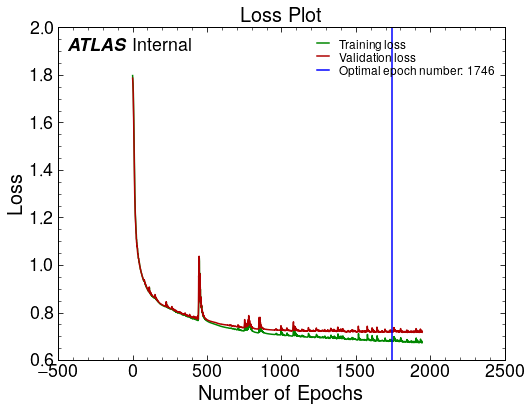

In [62]:
loss_plotter(
    framework_type = framework_type,
    model = loss_history
)

#### Feature Importance

Calculating the feature importance scores using SHAP.

In [63]:
from FeatureImportanceCalculator import feature_importance_calculator

In [64]:
explainer, shap_values, df_feature_importance_scores = feature_importance_calculator(
    framework_type = framework_type,
    algorithm_type = algorithm_type,
    model = pytorch_model,
    X_train = X_train_tensor,
    X_test = X_test_tensor,
    columns = X_train.columns,
    events = 1000
)

In [65]:
df_feature_importance_scores.head(10)

name  mean_abs_shap  stdev_abs_shap
0         nVtx       0.037102        0.043190
1   LeptonVeto       0.403954        0.530368
2        tau_n       0.185905        0.393111
3        jet_n       0.078245        0.116023
4   jet_n_btag       0.255843        0.354984
5        ele_n       0.137121        0.361060
6         mu_n       0.109887        0.265732
7        sumMT       0.309897        0.725002
8     sumMTJet       0.126002        0.180055
9  sumMTTauJet       0.152397        0.194140

Plotting the feature importance scores.
* for the whole spectrum (horizontally and vertically),
* for the 20 most important features (horizontally and vertically),
* for the 20 most important features (horizontally) including dinstinction to individual classes.

In [66]:
from FeatureImportancePlotter import feature_importance_plotter

Plotting the feature importance scores for the whole spectrum (vertically).

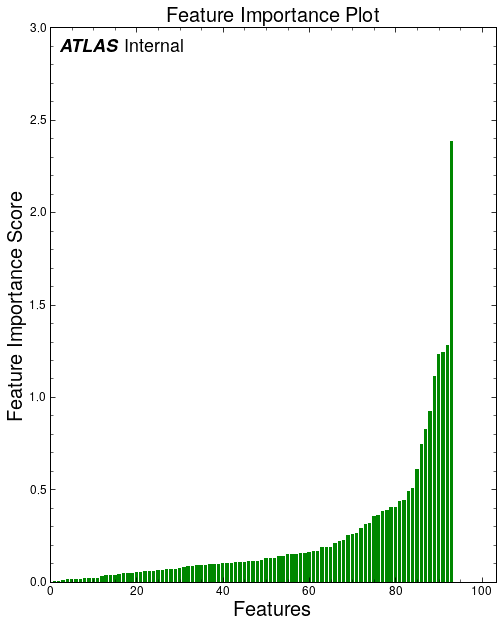

In [67]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train_tensor,
    X_test = X_test_tensor,

    direction = 'vertical',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = None,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the whole spectrum (horizontally).

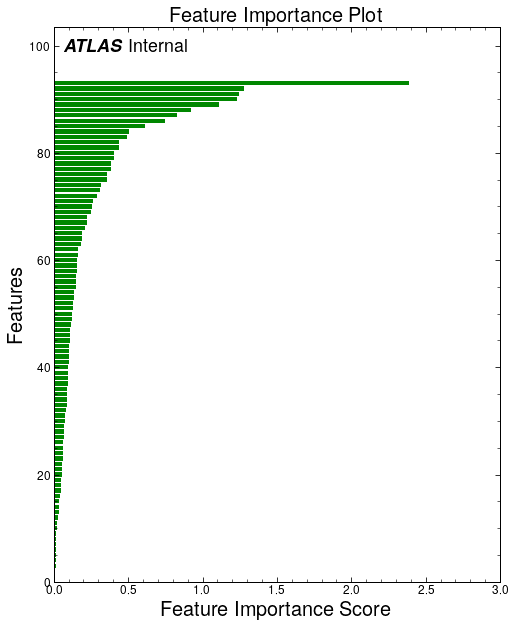

In [68]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train_tensor,
    X_test = X_test_tensor,

    direction = 'horizontal',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = None,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the 20 most important features (vertically).

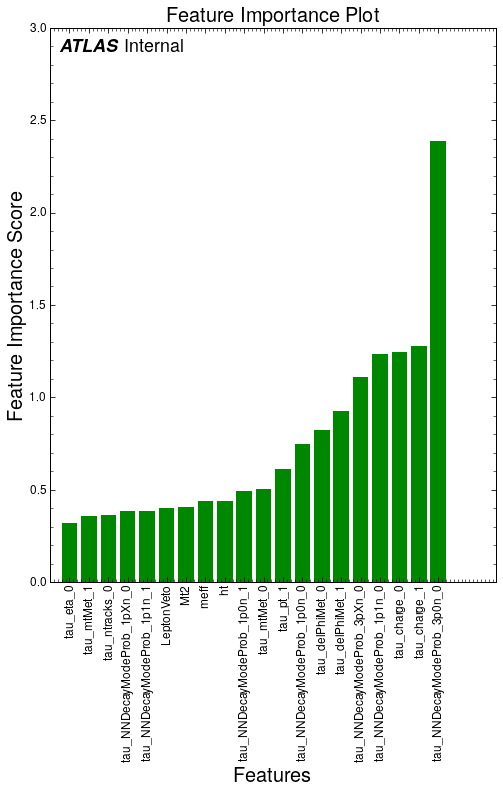

In [69]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train_tensor,
    X_test = X_test_tensor,

    direction = 'vertical',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = 20,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the 20 most important features (horizontally).

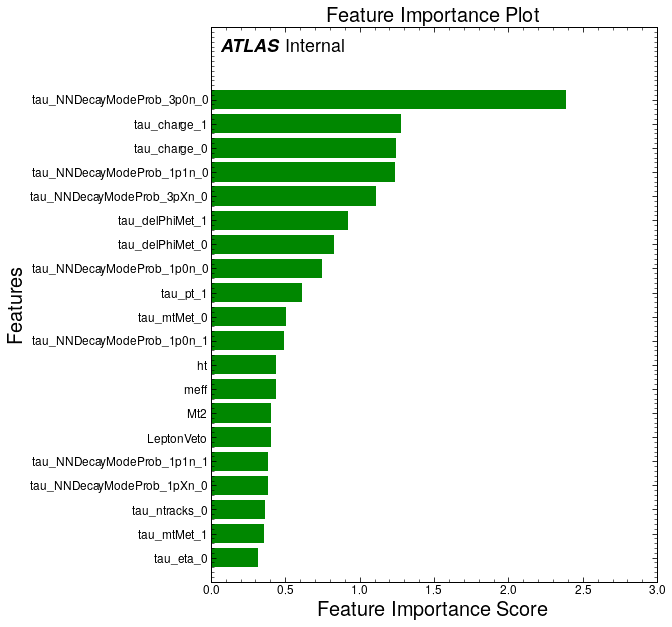

In [70]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train_tensor,
    X_test = X_test_tensor,

    direction = 'horizontal',

    shap = 'SHAP',
    classes = 'as_one',

    n_features = 20,
    columns = X.columns,
    labels = dataframe['labels']
)

Plotting the feature importance scores for the 20 most important features with distinction of individual classes.

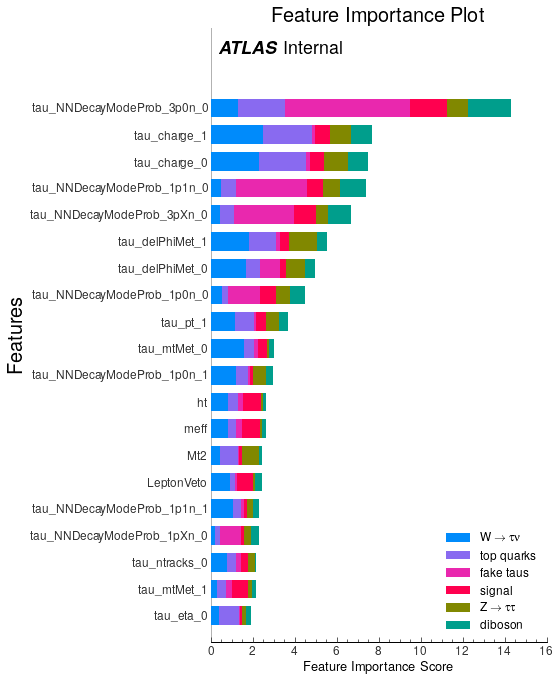

In [71]:
feature_importance_plotter(
    framework_type = framework_type,
    model = df_feature_importance_scores,
    X_train = X_train_tensor,
    X_test = X_test_tensor,

    direction = 'horizontal',

    shap = 'SHAP',
    classes = 'as_many',
    shap_values = shap_values,

    n_features = 20,
    columns = X.columns,
    labels = dataframe['labels']
)

### Evaluation Metrics

#### Output

In [72]:
from ResultsPresenter import results_presenter

In [73]:
dict_results, df_results = results_presenter(
    framework_type = framework_type,
    algorithm_type = algorithm_type,
    y_test = y_test_tensor,
    predictions = y_pred_val,
)

Displaying obtained results.

In [74]:
df_results

y_test                                   y_logits  \
0            5  [-1.54, -3.91, -5.52, -0.65, -0.56, 4.75]   
1            3    [-2.61, -0.73, -2.26, 1.53, 0.05, 2.53]   
2            2     [-3.25, 0.22, 4.07, 2.2, -0.87, -5.64]   
3            5   [-6.06, -2.37, -2.24, 2.64, -3.04, 4.81]   
4            5    [-5.84, -4.67, -2.99, 0.27, -4.85, 9.2]   
...        ...                                        ...   
416619       5    [-3.5, -6.73, -1.45, 0.94, -1.37, 7.26]   
416620       5   [-7.72, -6.46, -5.38, 3.99, -1.07, 7.76]   
416621       1      [-1.16, 3.91, 0.4, 1.3, -1.24, -3.22]   
416622       2    [-0.05, 2.97, -1.47, 1.02, -2.29, -0.4]   
416623       4    [2.73, -5.57, -3.95, -2.01, 3.33, -1.9]   

                            y_probabilities  y_predictions  
0           [0.0, 0.0, 0.0, 0.0, 0.0, 0.99]              5  
1       [0.0, 0.03, 0.01, 0.24, 0.06, 0.66]              5  
2        [0.0, 0.02, 0.84, 0.13, 0.01, 0.0]              2  
3            [0.0, 0.0, 0.0, 0.1, 0.0, 0.9]              5  
4            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]              5  
...                                     ...            ...  
416619       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]              5  
416620     [0.0, 0.0, 0.0, 0.02, 0.0, 0.98]              5  
416621   [0.01, 0.9, 0.03, 0.07, 0.01, 0.0]              1  
416622  [0.04, 0.81, 0.01, 0.11, 0.0, 0.03]              1  
416623     [0.35, 0.0, 0.0, 0.0, 0.64, 0.0]              4  

[416624 rows x 4 columns]

#### Scores

Displaying calculated scores.

In [75]:
from ScoresPrinter import scores_printer

In [76]:
scores_printer(
    algorithm_type = algorithm_type, 
    y_test = dict_results['y_test'],
    predictions = dict_results['y_predictions'],
)

Precision Score | Accuracy (Micro Average): 81.17%
Precision Score | Macro Average: 59.12%
Precision Score | Weighted Average: 87.11%
Recall Score | Accuracy (Micro Average): 81.17%
Recall Score | Macro Average: 73.94%
Recall Score | Weighted Average: 81.17%
F1 Score | Accuracy (Micro Average): 81.17%
F1 Score | Macro Average: 61.31%
F1 Score | Weighted Average: 83.48%


#### Classification Report

Printing a classification report and a support (for binary- and multiclass-classification). A support is the number of entries each class has.

In [77]:
from ClassificationReportPlotter import classification_report_plotter

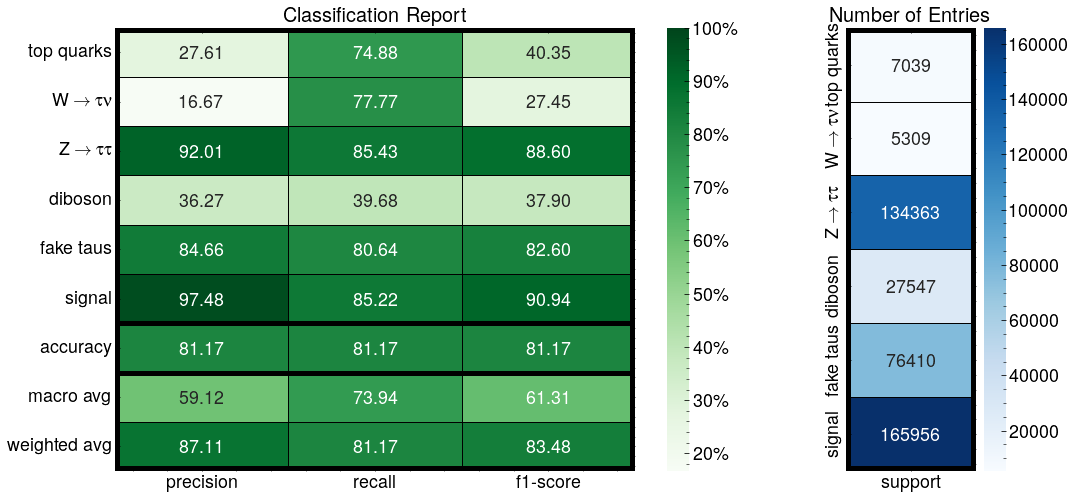

In [78]:
classification_report_plotter(
    algorithm_type = algorithm_type, 
    y_test = dict_results['y_test'],
    predictions = dict_results['y_predictions'],
    labels = dataframe['labels']
)

#### Confusion Matrix

Displaying a confusion matrix in terms of recall scoring (for binary- and multiclass-classification).

In [79]:
from ConfusionMatrixPlotter import confusion_matrix_plotter

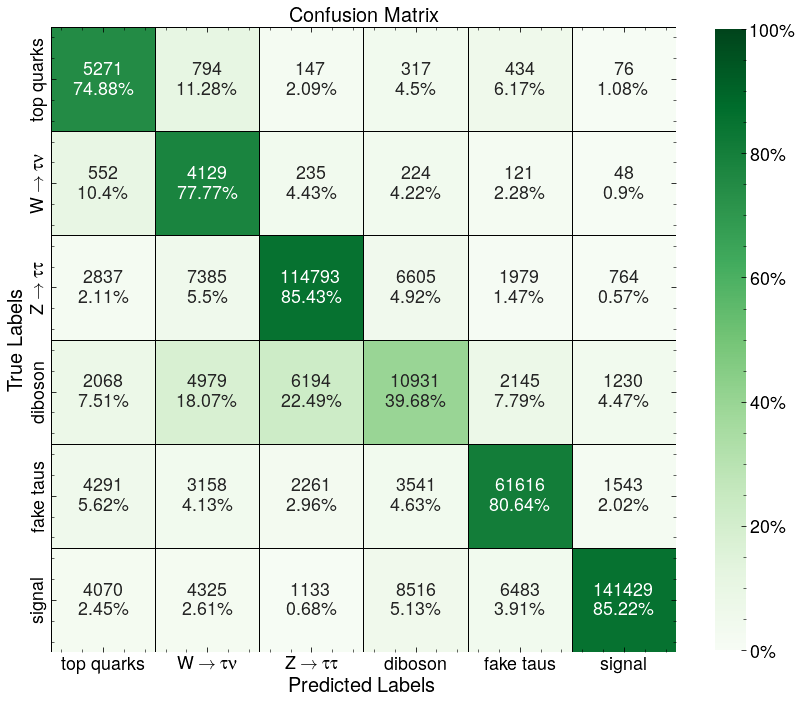

In [80]:
confusion_matrix_plotter(
    algorithm_type = algorithm_type, 
    y_test = df_results['y_test'],
    predictions = dict_results['y_predictions'],
    labels = dataframe['labels']
)

#### ROC & PR Curve

Displaying a Receiver Operating Characteristic and Precision-Recall Curve (for binary- and multiclass-classification).

In [86]:
from CurvePlotter import curve_plotter

<b> Receiver Operating Characteristic Curve. </b>

Manually calculating ROC AUC (based on the predictions):

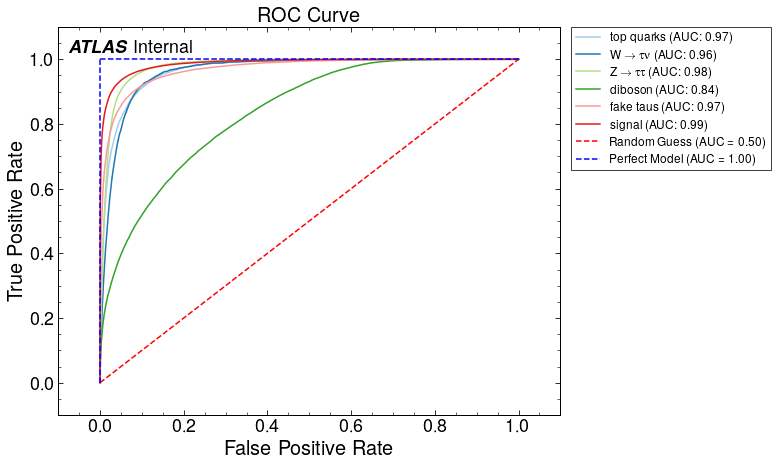

In [82]:
curve_plotter(
    framework_type = framework_type, 
    algorithm_type = algorithm_type, 
    curve_type = 'roc', 
    model = None, 
    y_test = dict_results['y_test'],
    X_test = X_test, 
    predictions = dict_results['y_predictions'],
    predictions_proba = dict_results['y_probabilities'],
    labels = dataframe['labels']
)

<b> Precision-Recall Curve. </b>

Manually calculating PR AP (based on the model):

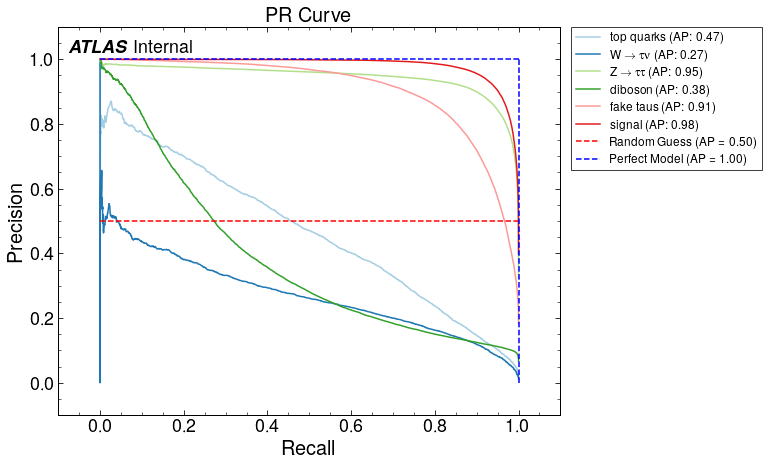

In [83]:
curve_plotter(
    framework_type = framework_type, 
    algorithm_type = algorithm_type, 
    curve_type = 'pr', 
    model = None, 
    y_test = dict_results['y_test'],
    X_test = X_test, 
    predictions = dict_results['y_predictions'],
    predictions_proba = dict_results['y_probabilities'],
    labels = dataframe['labels']
)

#### Network Visual

Displaying a neural network structure.

In [84]:
# from torchviz import make_dot

In [85]:
# from torchview import draw_graph

## Serialization

Organizing the PyTorch output.

In [87]:
output_pytorch = {
    'meta': dataframe['meta'],
    'region': dataframe['region'],
    'include': dataframe['include'],
    'labels': dataframe['labels'],
    'ML-info': {
        'framework_type': framework_type,
        'algorithm_type': algorithm_type,
        'criterion': criterion
    },
    'output': {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_selection_name': X_train_selection_name,
        'X_test_selection_name': X_test_selection_name,
        'X_test_weights': X_test_weights,
        'X_train_weights': X_train_weights,
        'X_class_test_weights': X_class_test_weights,
        'X_class_train_weights': X_class_train_weights,
        'dict_results': dict_results,
        'df_results': df_results
    },
}

Serializing the PyTorch output.

In [88]:
with open(f"{path_pickles}/ML/{analysis_base}/{run}/{region}/{channel}_tau/output_pytorch.pkl", "wb") as file:
    pickle.dump(output_pytorch, file)